In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_excel("dataIndia.xlsx")
df.Date=pd.to_datetime(df.Date,infer_datetime_format=True)
State_name="Maharashtra"


### Creating Data Frame with Confirmed and Cured lags

In [5]:
#State of Maharashtra

df.index = pd.DatetimeIndex(df.Date)
df_State=df[df['State/UnionTerritory']==State_name]
#df_State=df_State.reindex(pd.date_range("2020-01-30", "2020-08-23"), fill_value=0)
df_State['Date']=df_State.index
df_State.reset_index(inplace = True, drop = True)
df_out={'Date': df_State.Date.to_list(),
             'Deaths':df_State.Deaths.to_list(),
            'ConLag7':df_State.Confirmed.shift(7).to_list(),
            'CurLag7':df_State.Cured.shift(7).to_list()
           }

df_out=pd.DataFrame(df_out)
df_out.columns
df_out=df_out.dropna()
df_out.set_index('Date',inplace=True)
for cols in df_out.columns:
    if cols=="Date":
        continue
    else:
        df_out[cols]=df_out[cols].astype(int)

In [6]:
df_out

,Deaths,ConLag7,CurLag7
Date,,,
2020-03-16,0,2,0
2020-03-17,1,5,0
2020-03-18,1,2,0
2020-03-19,1,11,0
2020-03-20,1,14,0
...,...,...,...
2020-08-29,23775,657450,470873
2020-08-30,24103,671942,480114
2020-08-31,24399,682383,488271


In [7]:
train=df_out[:]
train


,Deaths,ConLag7,CurLag7
Date,,,
2020-03-16,0,2,0
2020-03-17,1,5,0
2020-03-18,1,2,0
2020-03-19,1,11,0
2020-03-20,1,14,0
...,...,...,...
2020-08-29,23775,657450,470873
2020-08-30,24103,671942,480114
2020-08-31,24399,682383,488271


In [8]:
y_train=train.pop('Deaths')
x_train=train

### Model Building using Linear Regression to select the feature

In [9]:
lm=LinearRegression()


In [10]:
import statsmodels.api as sm  
x_train = sm.add_constant(x_train)
x_train

,const,ConLag7,CurLag7
Date,,,
2020-03-16,1.0,2,0
2020-03-17,1.0,5,0
2020-03-18,1.0,2,0
2020-03-19,1.0,11,0
2020-03-20,1.0,14,0
...,...,...,...
2020-08-29,1.0,657450,470873
2020-08-30,1.0,671942,480114
2020-08-31,1.0,682383,488271


In [11]:
lm = sm.OLS(y_train, x_train).fit()   
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.621e+04
Date:                Fri, 04 Sep 2020   Prob (F-statistic):          6.87e-193
Time:                        13:03:43   Log-Likelihood:                -1321.4
No. Observations:                 171   AIC:                             2649.
Df Residuals:                     168   BIC:                             2658.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.8568     64.839      1.247      0.2

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,ConLag7,78.08
2,CurLag7,78.08
0,const,2.34


#### We will use ```Confirmed Lag 7``` and ```Cured Lag 7``` as the external regressors to forecast death for the next five days because they have low p-value and low vif score.We can use both of them together or individually. 

### Model Forecasting using Prophet for next seven days
    * using confirmed lag 7
    * using cured lag 7

In [14]:
from fbprophet import Prophet

In [15]:
def forecasting(df_out,regressor,table,graph):
    
    df_out1=pd.DataFrame(columns=["ds","y"]) 
    
        
    df_out1['y']=df_out['Deaths']
    df_out1['ds']=df_out.index
    
    if regressor=="Confirmed":
        df_out1['ConLag7']=df_out['ConLag7']
    elif regressor=="Cured":
        df_out1['CurLag7']=df_out['CurLag7']
    else:
        df_out1['ConLag7']=df_out['ConLag7']
        df_out1['CurLag7']=df_out['CurLag7']
        
        
    df_out1.reset_index(inplace=True,drop=True)
    
    #print(df_out1)
    
        
    model=Prophet(daily_seasonality=True,yearly_seasonality=False)
    
    if regressor=="Confirmed":
        model.add_regressor('ConLag7')
    elif regressor=="Cured":
        model.add_regressor('CurLag7')
    else:
        model.add_regressor('ConLag7')
        model.add_regressor('CurLag7')
        
    #print(df_out)    
    model.fit(df_out1)
    
    future = model.make_future_dataframe(periods=7)
    
    if regressor=="Confirmed":
        conlag=list(df_out1['ConLag7'])
        for i in range(7,0,-1):
            conlag.append(list(df_State['Confirmed'])[-i])
        #print(conlag)
            
        future['ConLag7']=list(conlag)
        #print(future)
    elif regressor=="Cured":
        curlag=list(df_out1['CurLag7'])
        #curlag.append(list(df_State['Cured'])[-1])
        for i in range(7,0,-1):
            curlag.append(list(df_State['Cured'])[-i])

        future['CurLag7']=list(curlag)
    else:
        conlag=list(df_out1['ConLag7'])
        for i in range(7,0,-1):
            conlag.append(list(df_State['Confirmed'])[-i])
        #conlag.append(list(df_State['Confirmed'])[-1])
        curlag=list(df_out1['CurLag7'])
        for i in range(7,0,-1):
            curlag.append(list(df_State['Cured'])[-i])
        #curlag.append(list(df_State['Cured'])[-1])
        future['ConLag7']=list(conlag)
        future['CurLag7']=list(curlag)
    #print(future)
    
    forecast=model.predict(future)
    if table=="Yes":
        print("Forecasted Table for number of Deaths for State: "+State_name+"\n")
        Forecast=pd.DataFrame()
        Forecast['Day']=forecast['ds']
        Forecast['Forecasted_Death']=[int(x) for x in list(forecast['yhat'])]
        Forecast['Lower Limit']=[int(x) for x in list(forecast['yhat_lower'])]
        Forecast['Upper Limit']=[int(x) for x in list(forecast['yhat_upper'])]
        Forecast.set_index('Day',inplace=True)
        print(Forecast.tail(7))
    if graph=="Yes":
        print("\nGraphs (Forecasted + Components) for number of Deaths for State: "+State_name)
        model.plot(forecast)
        model.plot_components(forecast)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Forecasted Table for number of Deaths for State: Maharashtra

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-03             25427        25312        25550
2020-09-04             25730        25601        25851
2020-09-05             26060        25926        26195
2020-09-06             26384        26250        26521
2020-09-07             26670        26531        26814
2020-09-08             26968        26833        27111
2020-09-09             27353        27203        27516

Graphs (Forecasted + Components) for number of Deaths for State: Maharashtra


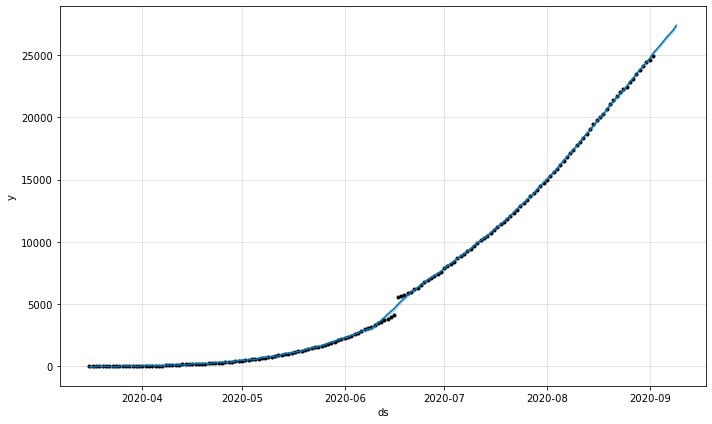

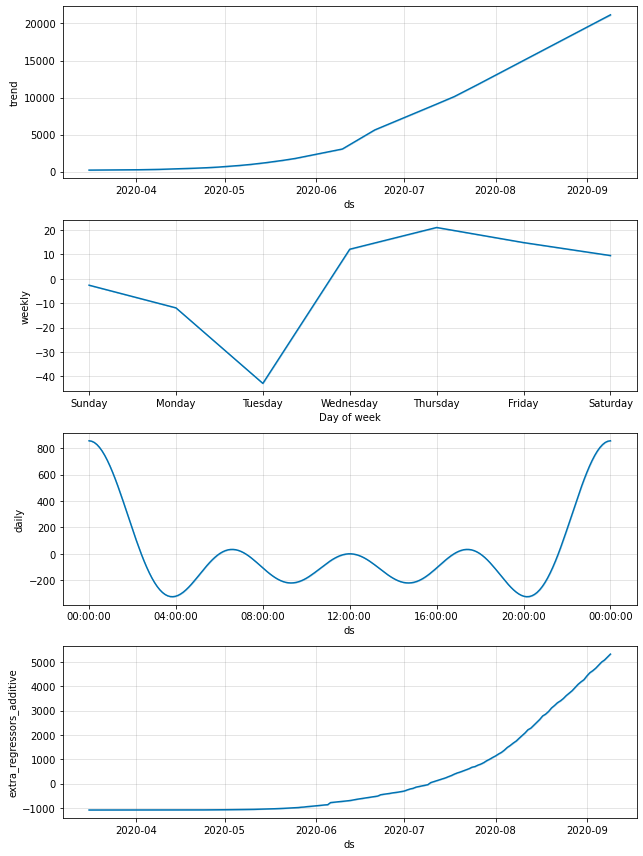

In [16]:
# df=pd.read_csv("prophet_covid.csv")
# #print(df.index)
# df.Date=pd.to_datetime(df.Date,infer_datetime_format=True)

# State_name="Maharashtra"

table="Yes"
graph="Yes"
regressor="Both"
forecasting(df_out,regressor,table,graph)